# Financial Markets - Practical Lesson 3

## Recap

In the first two lessons we looked at:

* Basic Python statements, expressions and objects (lists, dictionaries)
* Dates, tuples and functions
* We started looking at how to implement functionality related to the theoretical lessons

## Today's lesson

We're going to look at:

* Last week's exercises
* Classes
* Modules

While we talk about these topics we're going to move ahead with implementing functionality related to the theory lessons.

In [1]:
# Exercise 1

# Take the code for the Black-Scholes formula from lesson 1's exercises and wrap it in a function

# Then, use the function to calculate the prices of calls with various
# strikes, using the following data

# The output should be a dictionary mapping strikes to call prices

s = 800
moneyness = [ 0.5, 0.75, 0.825, 1.0, 1.125, 1.25, 1.5 ]   # strikes expressed as % of spot price
vol = 0.3
ttm = 0.75
r = 0.005

### Solution ###

from math import log,exp
from scipy.stats import norm

# Define a function that takes the usual Black Scholes parameters and returns the price of a call
def bs_call(s, k, r, vol, ttm):
    d1 = (log(s / k) + (r + 0.5 * vol ** 2) * ttm) / (vol * ttm ** 0.5)
    d2 = (log(s / k) + (r - 0.5 * vol ** 2) * ttm) / (vol * ttm ** 0.5)
    call_price = s * norm.cdf(d1) - k * exp(-r * ttm) * norm.cdf(d2)   
    return call_price

# Build the dictionary by iterating over the items in the moneyness list
d = {
    s * m: bs_call(s, s * m, r, vol, ttm)
    for m in moneyness
}

d

{400.0: 401.66074527896365,
 600.0: 213.9883852521275,
 660.0: 166.85957363897398,
 800.0: 84.036970176603575,
 900.0: 47.618803946962288,
 1000.0: 25.632722952585738,
 1200.0: 6.6552752277711562}

In [2]:
# Exercise 2

# Python has a useful command called `assert` which can be used for checking that a given
# condition is satisfied, and raising an error if the condition not satisfied.

# The following line does not cause an error, in fact it does nothing
assert 1 < 2

# This causes an error
# assert 1 > 2

# Take the df function from lesson 2 and modify it by adding some assertions to check that:
# * The pillar date list contains at least 2 elements
# * The pillar date list is the same length as the discount factor list
# * The first pillar date is equal to the today date
# * The value date argument 'd' is greater or equal to the first pillar date
#     and also less than or equal to the last pillar date

# Then try using the function with some invalid data to make sure that your assertions are
# correctly checking the desired conditions


### Solution ###


# import modules and objects that we need
from datetime import date
import numpy
import math

# define the input data

today_date = date(2016, 1, 1)

pillar_dates = [
    date(2016, 1, 1),
    date(2017, 1, 1),
    date(2018, 1, 1)
]

discount_factors = [
    1.0,
    0.95,
    0.8
]


# define the df function
def df(d):
    
    ############## CHECKS ################
    
    # Check that there are at least 2 pillar dates
    assert len(pillar_dates) >= 2
    
    # Check that the number of pillar dates is equal to the number of pillar discount factors
    assert len(pillar_dates) == len(discount_factors)
    
    # Check that the first pillar date is the today date
    assert today_date == pillar_dates[0]
    
    # Check that the value date argument is between the first and last pillar dates
    assert pillar_dates[0] <= d <= pillar_dates[-1], "Invalid value date %s" % (d)
    
    ############## END OF CHECKS ################
    
    # first thing we need to do is to apply the logarithm function to the discount factors
    # since we are doing log-linear interpolation, not just linear interpolation
    log_discount_factors = [ math.log(discount_factor) for discount_factor in discount_factors ]
    
    # convert the pillar dates to pillar 'days', i.e. number of days from today
    pillar_days = [ (pillar_date - today_date).days for pillar_date in pillar_dates ]
    
    # obviously we need to do the same to the value date argument of the df function
    d_days = (d - today_date).days

    # perform the linear interpolation of the log discount factors
    interpolated_log_discount_factor = numpy.interp(d_days, pillar_days, log_discount_factors)
    
    # return the interpolated discount factor
    return math.exp(interpolated_log_discount_factor)

df(date(2019, 1, 1))

AssertionError: Invalid value date 2019-01-01

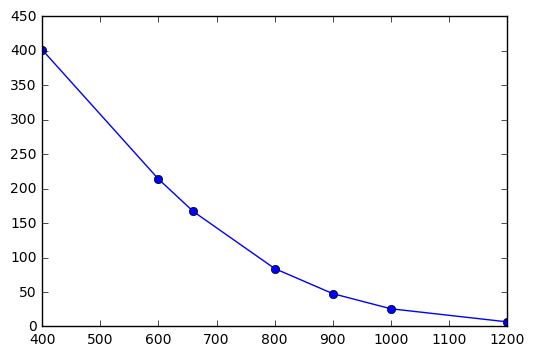

In [3]:
# Exercise 3

# Anaconda comes with a module called 'matplotlib' which can be used for plotting graphs
# and charts within a notebook. In particular, we can use a sub-module called 'pyplot' which
# provides slightly easier-to-use interface for plotting interactively.

# you need this otherwise the graphs might appear in a different window
%matplotlib inline

# import matplotlib.pyplot
from matplotlib import pyplot

# calculate a list of strikes
strikes = [ s*m for m in moneyness ]

# calculate a list of call prices
call_prices = [ bs_call(s, s * m, r, vol, ttm) for m in moneyness ]

# plot the data
pyplot.plot(
    strikes,   # x-axis coordinates
    call_prices,  # y-axis coordinates
    marker='o'   # we want the points to be marked with circles
)

# use this function to plot the call prices from exercise 1

## Calculating forward libor rates

Last week we wrote a function called `df` for calculating a discount factor at any date, given a set of discount factors each relative to a corrisponding pillar dates, using log-linear interpolation.

We will now use the previous function to calculate forward libor rates, using the following formula:

$$
F(T_1, T_2) = \frac{1}{T_2 - T_1}\left( \frac{D(T_1)}{D(T_2)} - 1 \right)
$$

In [4]:
from datetime import date

def forward_libor(d1, d2):
    return (df(d1) / df(d2) - 1) / ((d2  - d1).days / 365)

forward_libor(date(2017, 10, 1), date(2017, 4, 1))

0.16465502499562035

Recall that in a previous theory lesson we talked about how after the 2008 financial crisis, one discount curve was no longer sufficient to correctly price all forward libor rates of all tenors. For example, if we want to calculate the net present value of a forward 6-month libor coupon, we need to simultaneously use two different discount curves:
* the 6-month libor curve for determining the forward rate
* the EONIA curve (assuming EUR cash collateral) for discounting the expected cash flow

So just to be clear, we're now going to explore how to implement the following calculation:

$$
\def\eonia{\mathrm{eonia}}
\def\libor{\mathrm{libor}}
D_\eonia(T_1) \times \frac{1}{T_2 - T_1}\left( \frac{D_\libor(T_1)}{D_\libor(T_2)} - 1 \right)
$$

Programming problem: we only have one `df` function, and one set of data. How can we generalise what we've done so far in such a way that we can conveniently do the above calculation?

One (bad) idea is to write a different discount factor function for each curve:

In [5]:
# Multiple df functions, with multiple datasets

# ...

eonia_pillar_dates = [
    date(2016, 1, 1),
    date(2017, 1, 1),
    date(2018, 1, 1)
]

eonia_discount_factors = [
    1.0,
    0.95,
    0.8
]

libor6m_pillar_dates = [
    date(2016, 1, 1),
    date(2016, 6, 1),
    date(2018, 1, 1)    
]

libor6m_discount_factors = [
    1.0,
    0.98,
    0.82
]

def df_eonia(d):
    log_discount_factors = [ math.log(discount_factor) for discount_factor in eonia_discount_factors ]
    pillar_days = [ (pillar_date - today_date).days for pillar_date in eonia_pillar_dates ]
    d_days = (d - today_date).days
    interpolated_log_discount_factor = numpy.interp(d_days, pillar_days, log_discount_factors)
    return math.exp(interpolated_log_discount_factor)

def df_libor(d):
    log_discount_factors = [ math.log(discount_factor) for discount_factor in libor6m_discount_factors ]
    pillar_days = [ (pillar_date - today_date).days for pillar_date in libor6m_pillar_dates ]
    d_days = (d - today_date).days
    interpolated_log_discount_factor = numpy.interp(d_days, pillar_days, log_discount_factors)
    return math.exp(interpolated_log_discount_factor)

def forward_libor(d1, d2):
    return (
        df_libor(d1) /
        df_libor(d2) - 1
    ) / ((d2  - d1).days / 365)

rate = forward_libor(date(2017, 10, 1), date(2017, 4, 1))
rate * df_eonia(date(2017, 10, 1))

0.09127780188264709

But this becomes pretty laborious, since we need to rewrite a function for every discount curve we add (for example, if we have another currency or more libor rates with different tenors). Also, if we want to change the behaviour of the `df` function (for example, change the type of interpolation), we then have to go and change each single implementation (`df_eonia`, `df_libor`, etc.) so it's not a convenient way of organizing the code.

An alternative could be to generalize the `df` function so that it takes the pillar dates and discount factors as arguments, then we pass in the data we want to use to calculate the interpolated discount factor in each specific case:

In [6]:
# One generalized df function, with multiple datasets

def df(pillar_dates, discount_factors, d):
    log_discount_factors = [ math.log(discount_factor) for discount_factor in discount_factors ]
    pillar_days = [ (pillar_date - today_date).days for pillar_date in pillar_dates ]
    d_days = (d - today_date).days
    interpolated_log_discount_factor = numpy.interp(d_days, pillar_days, log_discount_factors)
    return math.exp(interpolated_log_discount_factor)

def forward_libor(d1, d2):
    return (
        df(libor6m_pillar_dates, libor6m_discount_factors, d1) /
        df(libor6m_pillar_dates, libor6m_discount_factors, d2) - 1
    ) / ((d2  - d1).days / 365)

rate = forward_libor(date(2017, 10, 1), date(2017, 4, 1))
rate * df(eonia_pillar_dates, eonia_discount_factors, date(2017, 10, 1))

0.09127780188264709

This is still very inconvenient though, because we always have to pass a set of static parameters to every function call. It's just about OK as long as the parameter set is small (like in this case - only two items) but as it gets larger it becomes unmanageable.

However, Python allows you to represent collections of objects with dictionaries. One idea could be, instead of passing a long list of data parameters to each function call, to group the datasets into dictionaries, and then pass the dictionary.

In [7]:
# One generalized df function, dictionaries for representing data sets

eonia_data = {
    "pillar_dates": [
        date(2016, 1, 1),
        date(2017, 1, 1),
        date(2018, 1, 1)
    ],
    "discount_factors": [
        1.0,
        0.95,
        0.8
    ]
}

libor6m_data = {
    "pillar_dates": [
        date(2016, 1, 1),
        date(2016, 6, 1),
        date(2018, 1, 1)    
    ],
    "discount_factors": [
        1.0,
        0.98,
        0.82        
    ]
}

def df(data, d):
    pillar_dates = data['pillar_dates']
    discount_factors = data['discount_factors']
    log_discount_factors = [ math.log(discount_factor) for discount_factor in discount_factors ]
    pillar_days = [ (pillar_date - today_date).days for pillar_date in pillar_dates ]
    d_days = (d - today_date).days
    interpolated_log_discount_factor = numpy.interp(d_days, pillar_days, log_discount_factors)
    return math.exp(interpolated_log_discount_factor)

def forward_libor(d1, d2):
    return (
        df(libor6m_data, d1) /
        df(libor6m_data, d2) - 1
    ) / ((d2  - d1).days / 365)

rate = forward_libor(date(2017, 10, 1), date(2017, 4, 1))
rate * df(eonia_data, date(2017, 10, 1))

0.09127780188264709

This design pattern, i.e. using dictionaries to group together data, and then having functions operate on those dictionaries, perhaps with a few additional parameters, is so useful that Python (and many other programming languages) have a built-in feature that allows you to do this conveniently: classes.

## Classes

Let's start with some terminology:

* A **class** is collection of related functions, and these are called the **methods** of the class.
* The methods act on **instances** of the class.
* An **instance** is basically a collection of related data.
* Each data item has a name, and those names are called the **attributes** of the class.

In summary, classes are collections functions that operate on a data set, and instances of that class represent individual data sets.

Class methods always take the instance `self` as the first argument, and fall into two categories:

* Normal methods which use or modify the instance attributes
* Special methods, which define the class's behaviour: you can spot these because they start and end with __two__ underscores `__`

There are lots of other things you can do with classes, but this is enough for now.

Let's take a look at an example:

In [8]:
from datetime import date

class Person(object):
    
    def __init__(self, name, date_of_birth):
        self.name = name
        self.date_of_birth = date_of_birth
        
    def age(self):
        today = date.today()
        age = today.year - self.date_of_birth.year
        if today.month < self.date_of_birth.month or today.day < self.date_of_birth.day:
            age -= 1
        return age


In [9]:
p = Person("Eric", date(1983, 11, 28))

In [10]:
p

In [11]:
p.name

'Eric'

In [12]:
p.date_of_birth

datetime.date(1983, 11, 28)

In [13]:
p.age()

32

In [14]:
def print_age(person):
    print("%s is %s years old right now" % (person.name, person.age()))

In [15]:
print_age(p)

Eric is 32 years old right now


In [16]:
q = Person("Gianni", date(1995, 3, 4))
print_age(q)

Gianni is 21 years old right now


## Back to discount curves

So now that we have an idea of what a class is, let's write a `DiscountCurve` class which contains the pillar dates and pillar discount factors as attributes, and which has methods for calculating the discount factor and forward libor rate at arbitrary dates.

In [17]:
class DiscountCurve(object):
    
    # the special __init__ method defines how to construct instances of the class
    def __init__(self, today, pillar_dates, discount_factors):
        
        # we just store the arguments as attributes of the instance
        
        self.today = today
        self.pillar_dates = pillar_dates
        self.discount_factors = discount_factors
        
        
    # calculates a discount factor at an arbitrary value date using the data stored in the instance
    def df(self, d):
        
        # these remain local variables, i.e. they are only available within the function
        # to read (or write) instance attributes, you always need to use the self. syntax
       
        log_discount_factors = [
            math.log(discount_factor)
            for discount_factor in self.discount_factors
        ]
        
        pillar_days = [
            (pillar_date - self.today).days
            for pillar_date in self.pillar_dates
        ]
        
        d_days = (d - self.today).days
        
        interpolated_log_discount_factor = numpy.interp(d_days, pillar_days, log_discount_factors)
        
        return math.exp(interpolated_log_discount_factor) 
    
    
    # calculates a forward libor rate based on the discount curve data stored in the instance
    def forward_libor(self, d1, d2):
       
        # we use the df method of the current instance to calculate the forward rate
        
        return (
            self.df(d1) /
            self.df(d2) - 1
        ) / ((d2  - d1).days / 365)

In [18]:
# build the EONIA curve object
eonia_curve = DiscountCurve(
    today=date(2016, 1, 1),     # n.b. here we use the 'keyword argument' syntax (today=..., pillar_dates=...)
    pillar_dates=[              # just so it's really clear what we're doing - it's not necessary, it's only for clarity
        date(2016, 1, 1),
        date(2017, 1, 1),
        date(2018, 1, 1)
    ],
    discount_factors=[
        1.0,
        0.95,
        0.8
    ]
)

# build the Libor curve object
libor_curve = DiscountCurve(
    today=date(2016, 1, 1),
    pillar_dates=[
        date(2016, 1, 1),
        date(2016, 6, 1),
        date(2018, 1, 1)    
    ],
    discount_factors=[
        1.0,
        0.98,
        0.82        
    ]
)    

In [19]:
eonia_curve.df(date(2017, 6, 1))

0.88480543087241

In [20]:
libor_curve.df(date(2017, 6, 1))

0.8758417107819354

In [21]:
libor_curve.forward_libor(date(2017, 10, 1), date(2017, 4, 1))

0.10926056065517761

In [22]:
eonia_curve.df(date(2017, 10, 1)) * libor_curve.forward_libor(date(2017, 10, 1), date(2017, 4, 1))

0.09127780188264709